<a href="https://colab.research.google.com/github/Nuri-Tas/Time-Series/blob/main/Forecasting/Prophet/ATM_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [360]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from warnings import simplefilter
simplefilter('ignore')

%matplotlib inline

In [361]:
plt.style.use('seaborn-whitegrid')

plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 5),
    titlesize=12,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

## Exploratory Data Analysis

Import ATM dataset and perform EDA. 

In [362]:
df = pd.read_excel('/content/ATM1_data.xlsx', skiprows=1, index_col=0, parse_dates=True)
df.head()

,CitySalaryCount,CitySalaryAmount,DistrictSalaryCount,DistrictSalaryAmount,DayOfWeek,WorkDayOfWeek,IsHoliday,DayOfMonth,WorkDayOfMonth,WithdrawalAmount,Unnamed: 11
WithdrawalDate,,,,,,,,,,,
2016-11-01,795,940359,184,263904,2,2,0,1,1,58620,NaN
2016-11-02,191,230139,126,119223,3,3,0,2,2,59860,NaN
2016-11-03,220,330021,92,128285,4,4,0,3,3,51840,NaN
2016-11-04,424,537056,385,473893,5,5,0,4,4,54560,NaN
2016-11-05,1096,1732373,388,568120,6,0,1,5,0,108230,NaN


Note that the last unnamed column generally contains null values except for a few rows displayed below. For the time being, we will drop this column:

In [363]:
df[df.iloc[:, -1].notna()]

,CitySalaryCount,CitySalaryAmount,DistrictSalaryCount,DistrictSalaryAmount,DayOfWeek,WorkDayOfWeek,IsHoliday,DayOfMonth,WorkDayOfMonth,WithdrawalAmount,Unnamed: 11
WithdrawalDate,,,,,,,,,,,
2016-11-15,2418,3858118,573,729778,2,2,0,15,11,48310,360.0
2016-11-16,190,200577,79,103586,3,3,0,16,12,91040,165.0
2016-12-04,14,10104,14,10104,7,0,1,4,0,25250,161.0
2016-12-05,534,702125,261,306996,1,1,0,5,3,81680,416.0
2016-12-17,2,500,2,500,6,0,1,17,0,55390,32.0
2017-01-21,85,71213,78,67128,6,0,1,21,0,42350,759.0


In [364]:
df.drop(columns=df.columns[-1], inplace=True)


Check for any mistaken datatypes, and null values:

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-11-01 to 2018-11-01
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   CitySalaryCount       731 non-null    int64
 1   CitySalaryAmount      731 non-null    int64
 2   DistrictSalaryCount   731 non-null    int64
 3   DistrictSalaryAmount  731 non-null    int64
 4   DayOfWeek             731 non-null    int64
 5   WorkDayOfWeek         731 non-null    int64
 6   IsHoliday             731 non-null    int64
 7   DayOfMonth            731 non-null    int64
 8   WorkDayOfMonth        731 non-null    int64
 9   WithdrawalAmount      731 non-null    int64
dtypes: int64(10)
memory usage: 62.8 KB


In [366]:
df.isna().sum()

CitySalaryCount         0
CitySalaryAmount        0
DistrictSalaryCount     0
DistrictSalaryAmount    0
DayOfWeek               0
WorkDayOfWeek           0
IsHoliday               0
DayOfMonth              0
WorkDayOfMonth          0
WithdrawalAmount        0
dtype: int64

The dataframe 6 different days for `WorkDayOfWeek`, and one of the `WorkDayOfWeek` (0) is also always `IsHoliday`  , and its count number is around 2 times of other work days, suggesting that 0 stands for both Saturday, and Sunday:

In [367]:
work_holiday = df.groupby(['WorkDayOfWeek', 'IsHoliday']).IsHoliday.count()
work_holiday

WorkDayOfWeek  IsHoliday
0              1            214
1              0            104
2              0            105
3              0            105
4              0            103
5              0            100
Name: IsHoliday, dtype: int64

Plot `WithdrawalAmount` against `DayOfWeek, DayOfMonth` and `WorkDayOfMonth`:

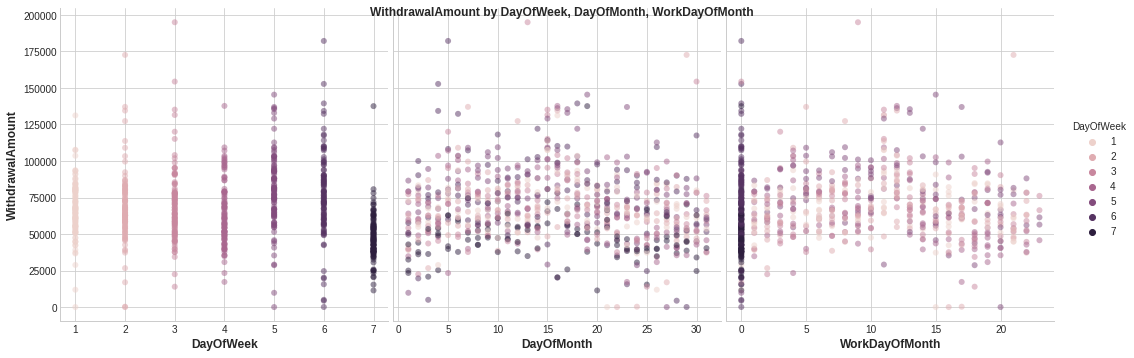

In [368]:
x_vars = ['DayOfWeek','DayOfMonth', 'WorkDayOfMonth']
sns.pairplot(df, x_vars= x_vars,
            y_vars='WithdrawalAmount',
             hue='DayOfWeek', 
             height=5,
             plot_kws={'alpha':0.5, 'linewidth':0},
             )

plt.suptitle(f"WithdrawalAmount by {', '.join(x_vars)}");

We observe several things from the pairplots above:


*   `WithdrawalAmount` shows a steady increase from `DayOfWeek` 1 to 6, and experiences a sharp dropoff on day 7. 
*  `WithdrawalAmount` tend to have an inverse U shape during `DayOfMonth` with relatively lower cash out at the beginning and end of months.
* There is a remarkably high frequency and large range of withdrawals on the `WorkDayOfMonth` 0. 






Let's see how `WithdrawalAmount` is distributed during holidays and workdays:

In [369]:
fig = px.histogram(df, x='WithdrawalAmount', title='WithdrawalAmount Distribution: Workdays vs Holidays',
                   color='IsHoliday',
                   marginal="box", 
                   text_auto=True,
                   hover_data=df.columns)
fig.update_layout()

We see that `WithdrawalAmount` has a median around 65K, and and the quarter values for `WithdrawalAmount` during workdays are slightly ahead of that of holidays.

Now, let's compare `CitySalaryCount, CitySalaryAmount, DistrictSalaryCount`, and `DistrictSalaryAmount`columns:

In [370]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

vars = df.columns[:4]
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(df.columns[:4]):
    fig.add_trace(
        go.Box(y=df[var],
        name=var,
        ),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

We notice that there are considerable amount of outliers in all four columns, and all have relatively small lower whiskers, namely there are less outliers at the bottom of plots. 

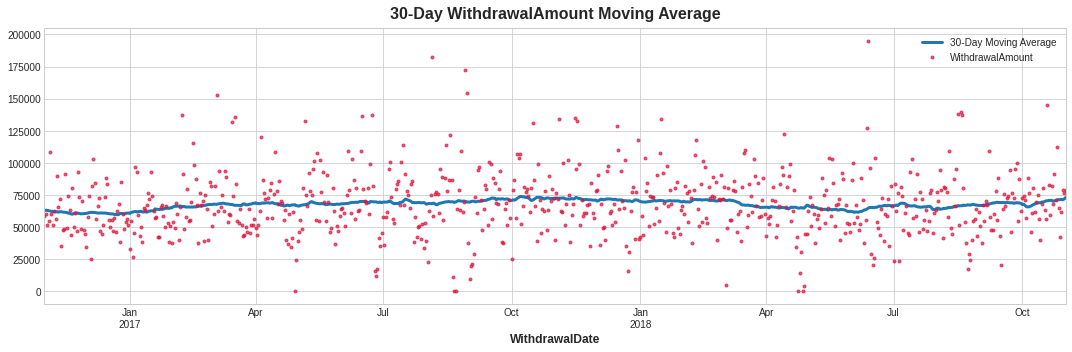

In [371]:









ax = df.WithdrawalAmount.rolling(window=90,
                            center=True,
                            min_periods=45).mean().plot(label='30-Day Moving Average', linewidth=3)

df.WithdrawalAmount.plot(style='.', ax=ax, alpha=0.7, title='30-Day WithdrawalAmount Moving Average', color='crimson')                           
ax.legend();

Take the mean `WithdrawalAmount` for each 5 day, display its trend, seasonal and residual plots:

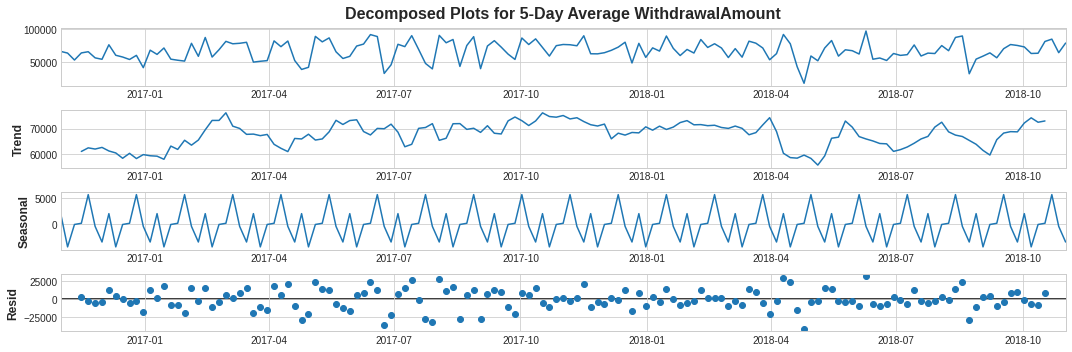

In [372]:
from statsmodels.tsa.seasonal import seasonal_decompose

five_day_avg = df.resample('5D').WithdrawalAmount.mean()
five_day_avg.name = 'Decomposed Plots for 5-Day Average WithdrawalAmount'

decomposed = seasonal_decompose(five_day_avg, model='additive')
ax = decomposed.plot();

There is no consistent trend in 5-Day average values, however there is a clear seasonality in values.  


Now, add an additional column showing the month number for each index and get violin plots of `WithdrawalAmount` per month:

In [373]:
from calendar import month_name
df['Month'] = df.index.month
df['Month'] = df.Month.apply(lambda x: month_name[x])

px.violin(df, x='Month', y='WithdrawalAmount', color='Month',
           category_orders={"Month": [month_name[i] for i in range(1, 13)]}
         )

June and August experiences the longest range of withdrawal amounts while `WithdrawalAmount` is surprisingly lower during July. 

**ACF Plot**

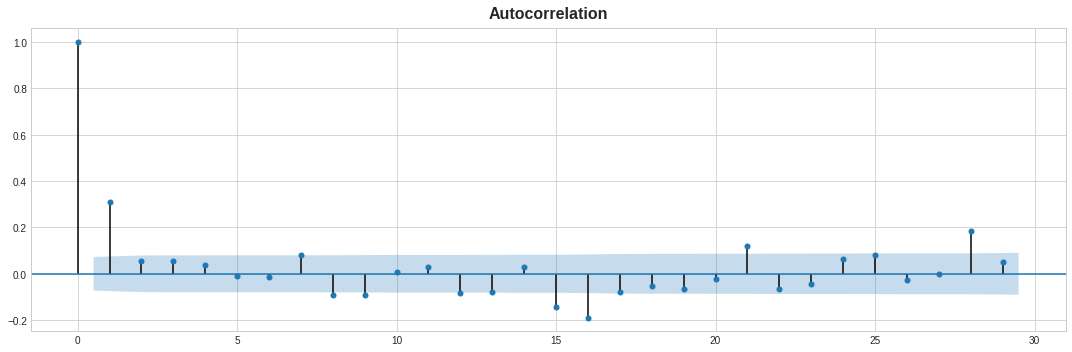

In [374]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.WithdrawalAmount,);

AutoCorrelation is around 0.3 with the first previous lagged values, and there is no significant autocorrelation with the rest of the lagged values.

**PACF Plot** 


Partial autocorrelation function (PACF) at lag $k$ is the correlation between $x_t$ and $x_{t-k}$ with the correlations effects coming from the elements up to $x_{t-k-1}$ removed. This definiton also implies that PACF at lag 1 is simply equals to autocorrelation.

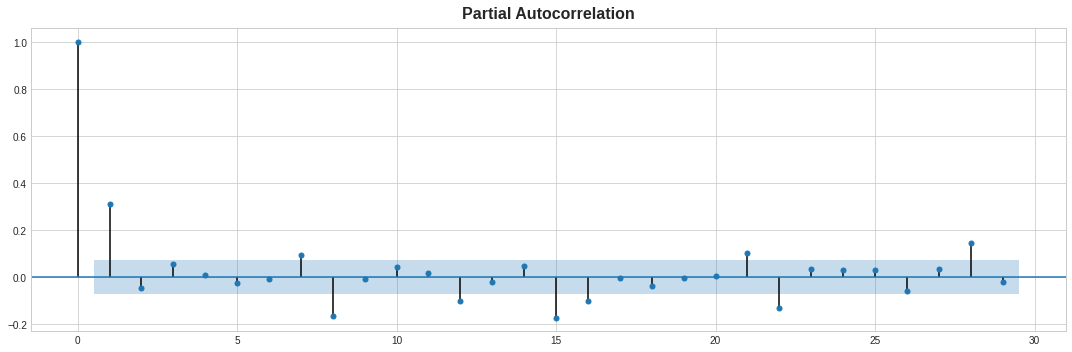

In [375]:
plot_pacf(df.WithdrawalAmount);

### Building a Model

Format the dataframe for Prophet, split the new dataframe and build the model. As the dataset contains about 800 days of `WithdrawalAmount` data, we will forecast values for 30, 60, and 90 days.

In [376]:
prophet_df = df.reset_index().iloc[:, [0, -2]].rename(columns={'WithdrawalDate':'ds', 'WithdrawalAmount':'y'})
prophet_df.head()

,ds,y
0,2016-11-01,58620
1,2016-11-02,59860
2,2016-11-03,51840
3,2016-11-04,54560
4,2016-11-05,108230


In [377]:
df.IsHoliday

WithdrawalDate
2016-11-01    0
2016-11-02    0
2016-11-03    0
2016-11-04    0
2016-11-05    1
             ..
2018-10-28    1
2018-10-29    0
2018-10-30    0
2018-10-31    0
2018-11-01    0
Name: IsHoliday, Length: 731, dtype: int64

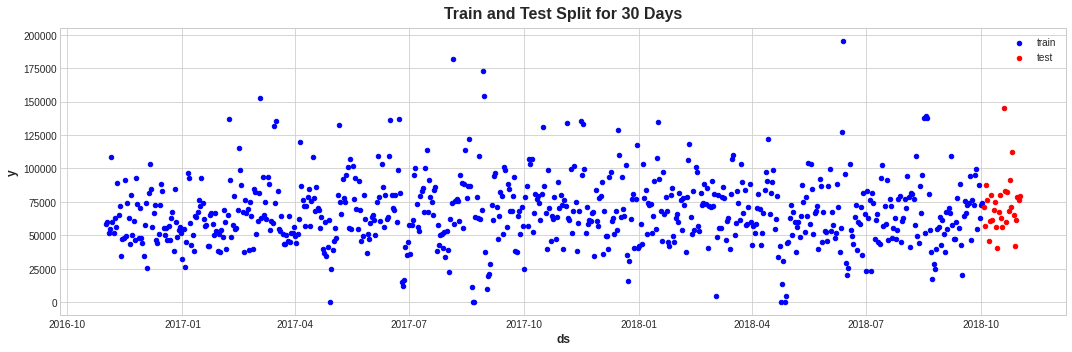

In [378]:
train = prophet_df.iloc[:-30]
test = prophet_df.iloc[-30:]

ax = train.plot.scatter(x='ds', y='y', color='b', label='train', title='Train and Test Split for 30 Days')
test.plot.scatter(x='ds', y='y', color='r',  ax=ax, label='test');

In [379]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 

def evaluate(test, forecast):
    metrics = [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error]
    results = []
    for metric in metrics:
         results.append(metric(test.y, forecast['yhat']))
    return results 

def forecast_(prophet_df, test_size, holiday_df=None):
  train = prophet_df.iloc[:-test_size]
  test = prophet_df.iloc[-test_size:]

  model = Prophet(holidays=holiday_df)
  model.fit(train)
  forecast = model.predict(test)
  
  results = evaluate(test, forecast)
  metrics = {'MAE': results[0], 'RMSE': np.sqrt(results[1]), 'MAPE': results[2]*100}

  return (model, forecast, metrics)

def get_plots(model, forecast):
  fig = model.plot(forecast, ylabel='WithdrawalAmount')
  ax = fig.gca()
  ax.set_title(f'{len(forecast)}-Day Forecasting', size=35)
  model.plot_components(forecast)  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/6zrb1ma8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/aem6pi21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49257', 'data', 'file=/tmp/tmp3izspyxx/6zrb1ma8.json', 'init=/tmp/tmp3izspyxx/aem6pi21.json', 'output', 'file=/tmp/tmppb7lbw2q/prophet_model-20220827130220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


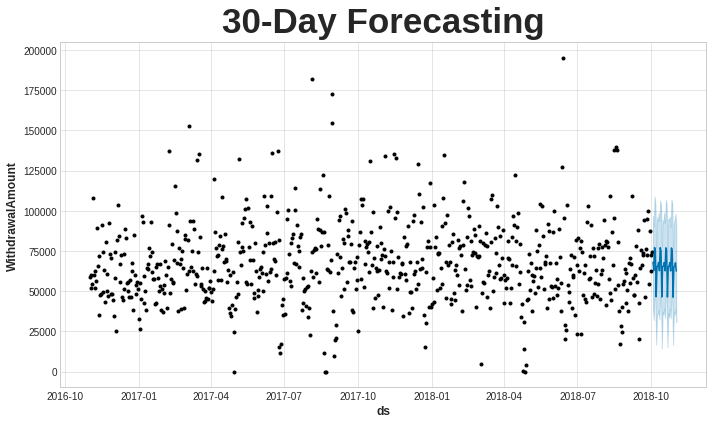

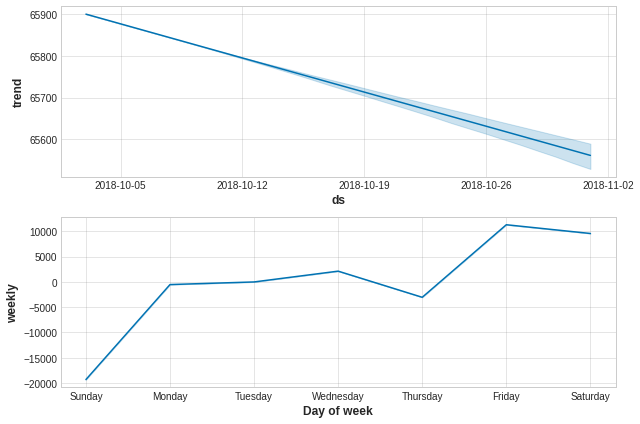

In [380]:
m, f, metrics_30 = forecast_(prophet_df, test_size=30)

get_plots(m, f)

## Evaluation

In [381]:
# Metrics for 30-Day Forecasting 
metrics_30

{'MAE': 11347.656208628427,
 'RMSE': 17230.832190428333,
 'MAPE': 13.941633067316184}

In [382]:
test.y.describe()

count        30.000000
mean      72161.166667
std       20417.492740
min       40230.000000
25%       60965.000000
50%       70220.000000
75%       79807.500000
max      145420.000000
Name: y, dtype: float64

Notes on evaluation metrics:


1. `MAE` is roughly equal to half standard deviation, namely the forecasted values are within half standard deviation of actual test values on average. 
2.   As it is shown above the minimum y value on the test set is `40230` while `RMSE` is `17230`, suggesting the model did pretty well on `RMSE` and did not give results that are way off than actual values. 
3. `MAPE` is roughly `14%`, and we can consider `MAPE` below `20%` a good value.



Let's run forecast also for 60, and 90 days inside the actual dataframe:

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/2b_v3vy4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/fyi4s862.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8670', 'data', 'file=/tmp/tmp3izspyxx/2b_v3vy4.json', 'init=/tmp/tmp3izspyxx/fyi4s862.json', 'output', 'file=/tmp/tmp1s7vkz_o/prophet_model-20220827130223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


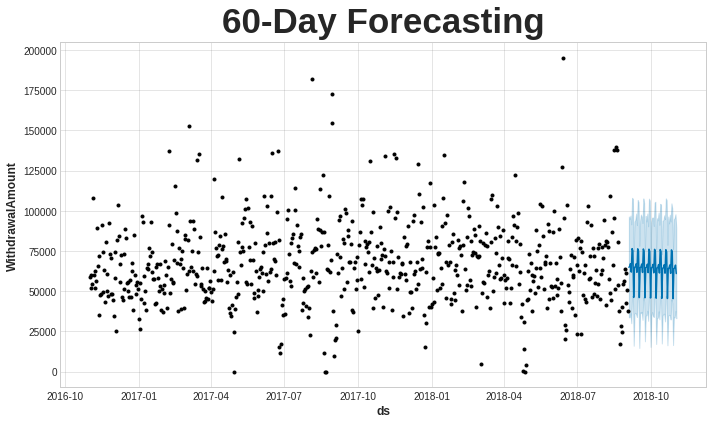

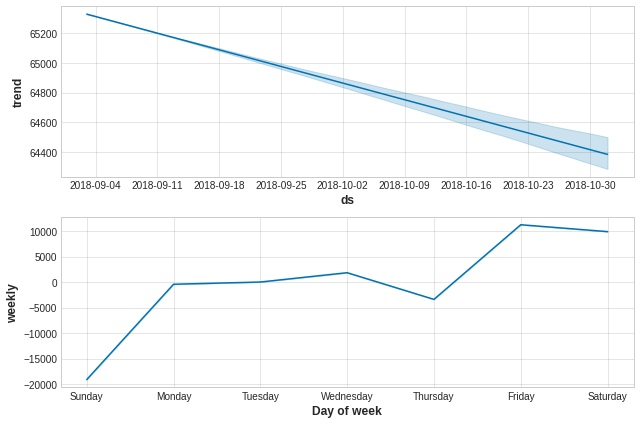

In [383]:
m, f, metrics_60 = forecast_(prophet_df, test_size=60)

get_plots(m, f)

In [384]:
metrics_60

{'MAE': 12183.778323693625,
 'RMSE': 17035.175262674376,
 'MAPE': 17.672490231741342}

For 60-day forecasting `MAE` and `RMSE` values did not differ too much, however `MAPE` value has reached to almost `18%` 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/bikinv1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/12bn1npy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80325', 'data', 'file=/tmp/tmp3izspyxx/bikinv1y.json', 'init=/tmp/tmp3izspyxx/12bn1npy.json', 'output', 'file=/tmp/tmpn8ungagm/prophet_model-20220827130227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


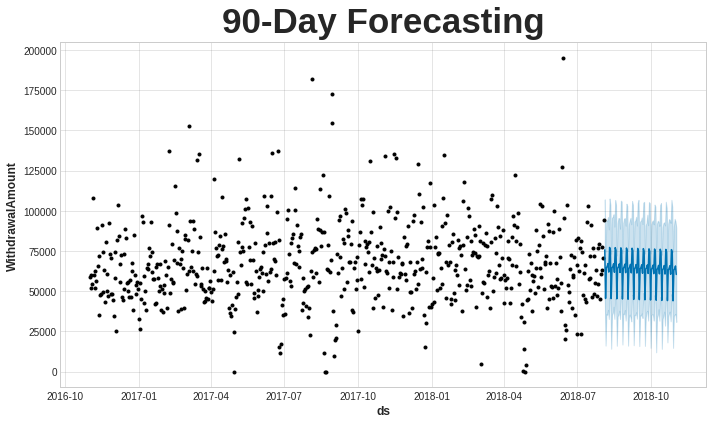

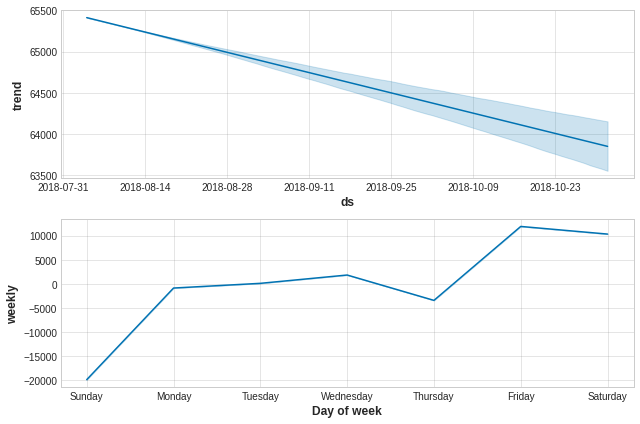

In [385]:
m, f, metrics_90 = forecast_(prophet_df, test_size=90)

get_plots(m, f)

In [386]:
metrics_90

{'MAE': 16176.301100709248,
 'RMSE': 23560.58532784917,
 'MAPE': 27.110941963061663}

90-day forecasting gave poor results overall:



1.   `RMSE` is now almost equal to standard deviation of the last 90-days (shown below)
2.   We also realize that `MAPE` has risen to almost `30%` for 90-day forecasting, which is way above of `20%`, so we will disregard this forecasting result.

In [387]:
prophet_df.iloc[-90:].y.describe()

count        90.000000
mean      68974.055556
std       24444.573085
min       17200.000000
25%       54712.500000
50%       67200.000000
75%       79807.500000
max      145420.000000
Name: y, dtype: float64

### Holiday Effect

`Prophet` also accepts holiday dates prior to training. We will now see if adding holidays will improve the accuracy of the model:

In [388]:
holiday_df = df[df.IsHoliday == 1].reset_index()[['WithdrawalDate', 'IsHoliday']].rename(columns={'WithdrawalDate':'ds', 'IsHoliday':'holiday'})
holiday_df.holiday = holiday_df.holiday.map({1: 'Holiday'})
holiday_df.head()

,ds,holiday
0,2016-11-05,Holiday
1,2016-11-06,Holiday
2,2016-11-12,Holiday
3,2016-11-13,Holiday
4,2016-11-19,Holiday


In [389]:
m, f_90_holiday, metrics_90_holiday = forecast_(prophet_df, test_size=90, holiday_df=holiday_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/myaa45q7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/slv5quhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36333', 'data', 'file=/tmp/tmp3izspyxx/myaa45q7.json', 'init=/tmp/tmp3izspyxx/slv5quhp.json', 'output', 'file=/tmp/tmpmzbvibn1/prophet_model-20220827130230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Let's create a dataframe of all forecasting results we have done so far.

In [426]:
metrics_df = pd.DataFrame({'No-Holiday': [forecast_(prophet_df, i)[2] for i in [30, 60, 90]], 'Holiday': [forecast_(prophet_df, i, holiday_df)[2] for i in [30, 60, 90]]})

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/f0re1y4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3izspyxx/8ex6vev1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56094', 'data', 'file=/tmp/tmp3izspyxx/f0re1y4a.json', 'init=/tmp/tmp3izspyxx/8ex6vev1.json', 'output', 'file=/tmp/tmpcsg0t3a0/prophet_model-20220827131727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:17:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yea

In [442]:
hol = metrics_df.Holiday.apply(pd.Series)
no_hol = metrics_df['No-Holiday'].apply(pd.Series)
hol.index = no_hol.index = [str(item) + '-Day' for item in [30, 60, 90]]

result_df = pd.concat([no_hol, hol], keys=['Normal Forecasting', 'Holiday Forecasting'])
result_df

MAE          RMSE       MAPE
Normal Forecasting  30-Day  11347.656209  17230.832190  13.941633
                    60-Day  12183.778324  17035.175263  17.672490
                    90-Day  16176.301101  23560.585328  27.110942
Holiday Forecasting 30-Day  11420.569224  17347.899983  13.935199
                    60-Day  12243.885455  17077.330811  17.704720
                    90-Day  16296.051221  23720.391590  26.961765

Overall, adding holiday dates into `Prophet` has given little to no improvement to the model accuracy, and forecasting metrics has gone worse and worse as we tried to predict the values for more into the future.
